## Tổng quan về dữ liệu

In [1]:
import pandas as pd

# Load the uploaded CSV files
links = pd.read_csv('data/links.csv')
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')

# Display basic information about the datasets to understand their structure
datasets_info = {
    "Links": links.head(),
    "Movies": movies.head(),
    "Ratings": ratings.head(),
    "Tags": tags.head()
}

datasets_shapes = {
    "Links Shape": links.shape,
    "Movies Shape": movies.shape,
    "Ratings Shape": ratings.shape,
    "Tags Shape": tags.shape
}

datasets_info, datasets_shapes


({'Links':    movieId  imdbId   tmdbId
  0        1  114709    862.0
  1        2  113497   8844.0
  2        3  113228  15602.0
  3        4  114885  31357.0
  4        5  113041  11862.0,
  'Movies':    movieId                               title  \
  0        1                    Toy Story (1995)   
  1        2                      Jumanji (1995)   
  2        3             Grumpier Old Men (1995)   
  3        4            Waiting to Exhale (1995)   
  4        5  Father of the Bride Part II (1995)   
  
                                          genres  
  0  Adventure|Animation|Children|Comedy|Fantasy  
  1                   Adventure|Children|Fantasy  
  2                               Comedy|Romance  
  3                         Comedy|Drama|Romance  
  4                                       Comedy  ,
  'Ratings':    userId  movieId  rating  timestamp
  0       1        1     4.0  964982703
  1       1        3     4.0  964981247
  2       1        6     4.0  964982224
  3    

## Trực quan hóa dữ liệu phù hợp với thuật toán đã chọn

### 1.Phân phối các đánh giá (rating) của người dùng

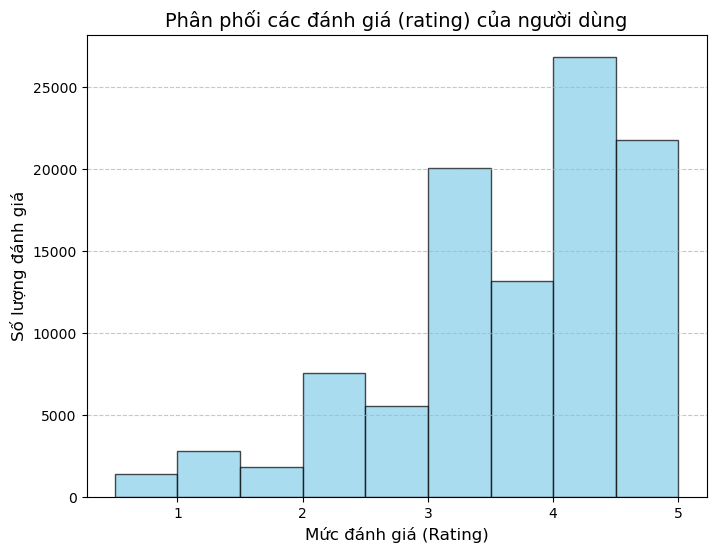

In [2]:
import matplotlib.pyplot as plt

# Tạo histogram phân phối các đánh giá (rating)
plt.figure(figsize=(8, 6))
plt.hist(ratings['rating'], bins=9, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Phân phối các đánh giá (rating) của người dùng', fontsize=14)
plt.xlabel('Mức đánh giá (Rating)', fontsize=12)
plt.ylabel('Số lượng đánh giá', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 2. Top 10 bộ phim được đánh giá nhiều nhất

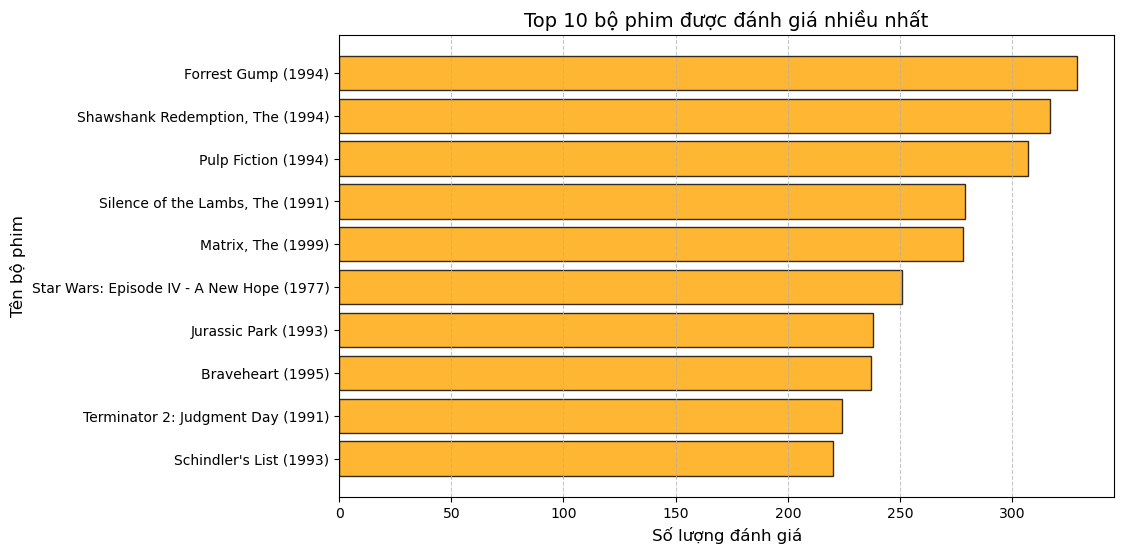

In [3]:
# Tính toán số lượng đánh giá cho từng bộ phim
top_movies = ratings['movieId'].value_counts().head(10)  # Lấy top 10 bộ phim được đánh giá nhiều nhất
top_movie_ids = top_movies.index
top_movies_with_titles = movies[movies['movieId'].isin(top_movie_ids)].set_index('movieId')
top_movies_with_titles = top_movies_with_titles.loc[top_movie_ids]  # Đảm bảo sắp xếp đúng thứ tự

# Tạo biểu đồ
plt.figure(figsize=(10, 6))
plt.barh(top_movies_with_titles['title'], top_movies, color='orange', edgecolor='black', alpha=0.8)
plt.title('Top 10 bộ phim được đánh giá nhiều nhất', fontsize=14)
plt.xlabel('Số lượng đánh giá', fontsize=12)
plt.ylabel('Tên bộ phim', fontsize=12)
plt.gca().invert_yaxis()  # Đảo ngược trục y để phim có số đánh giá cao nhất nằm trên cùng
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


### Tương quan giữa số lượng đánh giá và điểm trung bình

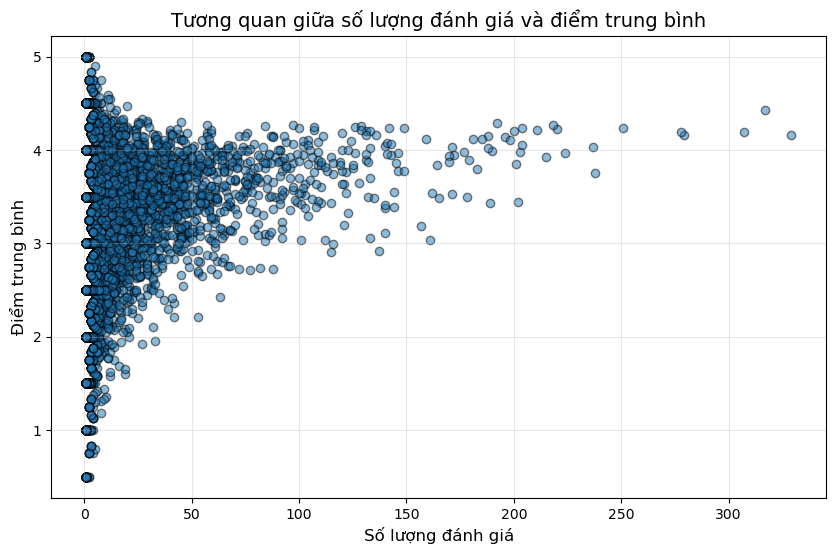

In [4]:
# Tính số lượng đánh giá và điểm trung bình cho từng bộ phim
movie_stats = ratings.groupby('movieId').agg(
    num_ratings=('rating', 'count'),
    avg_rating=('rating', 'mean')
).reset_index()

# Lấy dữ liệu của các bộ phim (kèm tiêu đề)
movie_stats_with_titles = movie_stats.merge(movies[['movieId', 'title']], on='movieId')

# Tạo biểu đồ scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(
    movie_stats['num_ratings'], 
    movie_stats['avg_rating'], 
    alpha=0.5, 
    edgecolors='black'
)
plt.title('Tương quan giữa số lượng đánh giá và điểm trung bình', fontsize=14)
plt.xlabel('Số lượng đánh giá', fontsize=12)
plt.ylabel('Điểm trung bình', fontsize=12)
plt.grid(alpha=0.3)

plt.show()


### 4. Phân bố số lượng bộ phim theo thể loại (Genres)

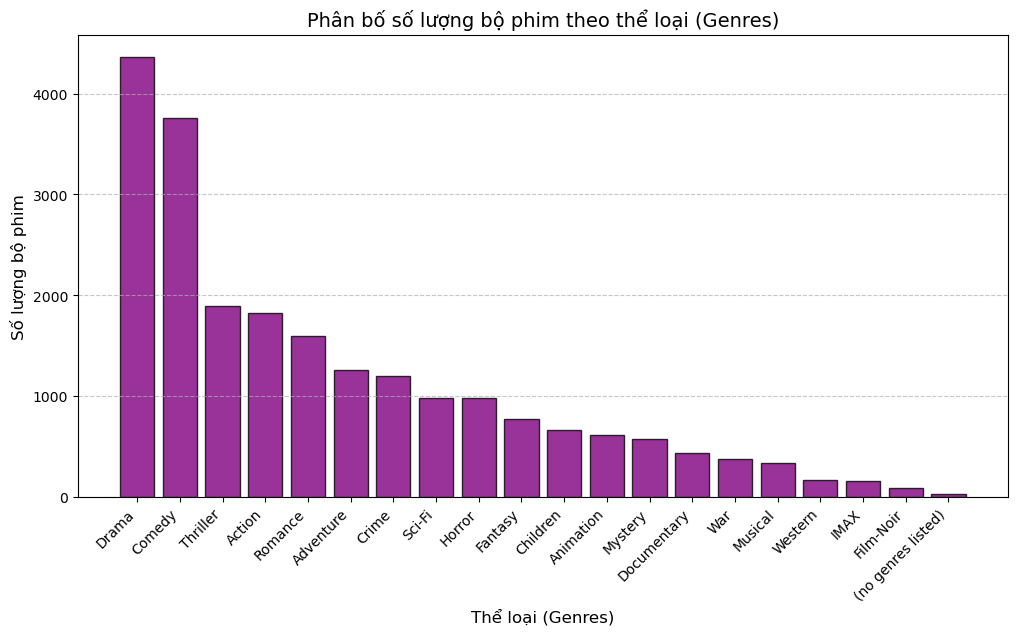

In [5]:
# Tách và đếm số lượng bộ phim theo thể loại (genres)
from collections import Counter

# Tách thể loại (genres) và đếm số lượng
all_genres = movies['genres'].str.split('|').explode()
genre_counts = Counter(all_genres)

# Chuyển đổi sang DataFrame để trực quan hóa
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Tạo biểu đồ bar chart
plt.figure(figsize=(12, 6))
plt.bar(genre_df['Genre'], genre_df['Count'], color='purple', edgecolor='black', alpha=0.8)
plt.title('Phân bố số lượng bộ phim theo thể loại (Genres)', fontsize=14)
plt.xlabel('Thể loại (Genres)', fontsize=12)
plt.ylabel('Số lượng bộ phim', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Ma trận tương đồng giữa các bộ phim phổ biến (Cosine Similarity) - Top 100 phim được đánh giá nhiều nhất

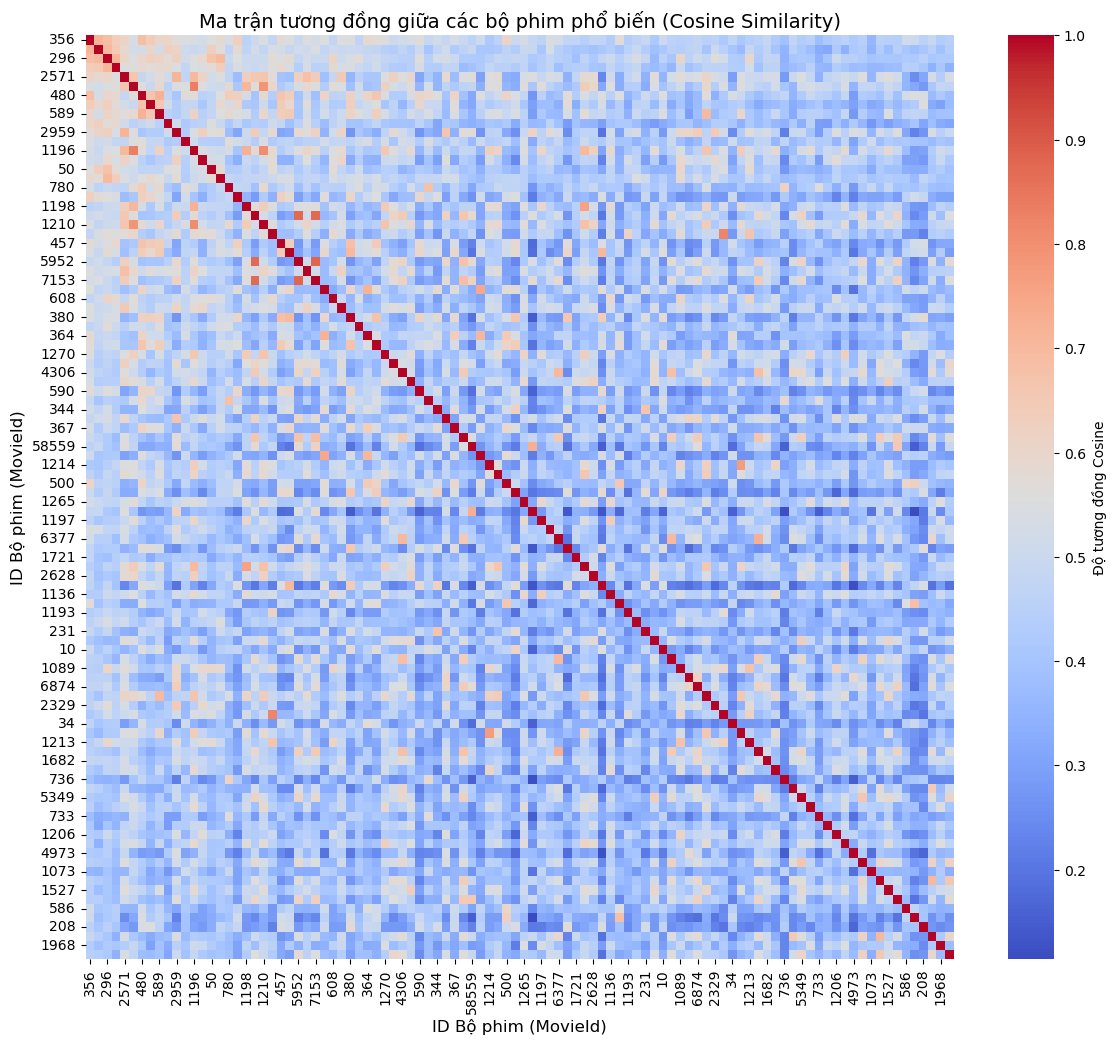

In [9]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Tạo ma trận User-Item
movie_user_matrix = ratings.pivot_table(
    index='movieId',  # Mỗi dòng là một bộ phim
    columns='userId',  # Mỗi cột là một người dùng
    values='rating'  # Giá trị là đánh giá của người dùng cho phim
)

# Lấy top 100 bộ phim được đánh giá nhiều nhất
top_100_movies = ratings['movieId'].value_counts().head(100).index
movie_user_matrix_small = movie_user_matrix.loc[top_100_movies]

# Điền giá trị NaN bằng 0
movie_user_matrix_small_filled = movie_user_matrix_small.fillna(0)

# Tính toán ma trận tương đồng cosine giữa các bộ phim (nhỏ hơn)
cosine_sim_matrix_small = cosine_similarity(movie_user_matrix_small_filled)

# Chuyển đổi thành DataFrame để dễ hiểu và trực quan hóa
cosine_sim_df_small = pd.DataFrame(
    cosine_sim_matrix_small,
    index=movie_user_matrix_small.index,
    columns=movie_user_matrix_small.index
)

# Tạo heatmap trực quan hóa ma trận tương đồng giữa các phim trong top 100
plt.figure(figsize=(14, 12))
sns.heatmap(
    cosine_sim_df_small,
    cmap='coolwarm',
    annot=False,
    cbar_kws={'label': 'Độ tương đồng Cosine'},
)
plt.title('Ma trận tương đồng giữa các bộ phim phổ biến (Cosine Similarity)', fontsize=14)
plt.xlabel('ID Bộ phim (MovieId)', fontsize=12)
plt.ylabel('ID Bộ phim (MovieId)', fontsize=12)
plt.show()


### 6. Phân bố số lượng đánh giá theo thời gian

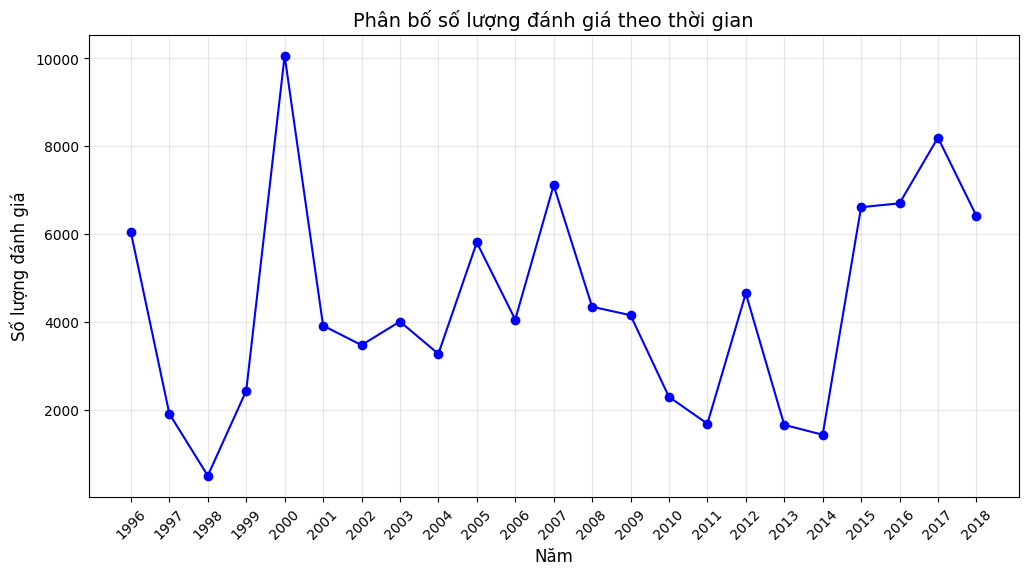

In [9]:
# Chuyển đổi timestamp trong tập dữ liệu ratings thành định dạng thời gian
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Tính toán số lượng đánh giá theo thời gian (theo năm)
ratings['year'] = ratings['timestamp'].dt.year
ratings_by_year = ratings.groupby('year').size()

# Tạo biểu đồ line chart để hiển thị số lượng đánh giá theo thời gian
plt.figure(figsize=(12, 6))
plt.plot(ratings_by_year.index, ratings_by_year.values, marker='o', linestyle='-', color='blue')
plt.title('Phân bố số lượng đánh giá theo thời gian', fontsize=14)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Số lượng đánh giá', fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(ratings_by_year.index, rotation=45)
plt.show()


### Tiền xử lý dữ liệu

In [10]:
# Kết hợp dữ liệu ratings và movies để tạo tệp dữ liệu gốc
data_combined = ratings.merge(movies, on='movieId', how='inner')

# Tiền xử lý dữ liệu:
# 1. Loại bỏ các cột không cần thiết (chỉ giữ lại các cột quan trọng)
data_cleaned = data_combined[['userId', 'movieId', 'title', 'genres', 'rating']]

# 2. Loại bỏ các bộ phim hoặc người dùng có quá ít đánh giá (lọc nhiễu)
# Lọc người dùng có ít hơn 5 đánh giá
active_users = data_cleaned['userId'].value_counts()
active_users = active_users[active_users >= 5].index
data_cleaned = data_cleaned[data_cleaned['userId'].isin(active_users)]

# Lọc phim có ít hơn 5 đánh giá
popular_movies = data_cleaned['movieId'].value_counts()
popular_movies = popular_movies[popular_movies >= 5].index
data_cleaned = data_cleaned[data_cleaned['movieId'].isin(popular_movies)]

# Lưu dữ liệu đã làm sạch thành file CSV
cleaned_file_path = 'data/data_cleaned.csv'
data_cleaned.to_csv(cleaned_file_path, index=False)

cleaned_file_path
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Ratings and Movies Cleaned Data", dataframe=data_cleaned)



Ratings and Movies Cleaned Data


## Huấn luyện mô hình và lưu mô hình

In [11]:
# Re-import all required libraries after the environment reset
import pandas as pd
from surprise import Dataset, Reader, SVD, SVDpp, KNNBasic, accuracy
from surprise.model_selection import train_test_split
from joblib import dump
from tabulate2 import tabulate

# Bước 1: Load dữ liệu đã làm sạch từ file CSV
data_path = 'data/data_cleaned.csv'
ratings_data = pd.read_csv(data_path)

# Bước 2: Định nghĩa một đối tượng Reader của thư viện Surprise
reader = Reader(rating_scale=(0.5, 5.0))

# Chuyển đổi dữ liệu từ DataFrame sang đối tượng Dataset của Surprise
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

# Bước 3: Chia tập dữ liệu thành 2 phần: tập huấn luyện (80%) và tập kiểm tra (20%) (random shuffle)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Bước 4: Định nghĩa các thuật toán và siêu tham số
algorithms = {
    "SVD": SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02),
    "SVD++": SVDpp(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02),
    "KNNBasic": KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': False})
}

# Bước 5: Huấn luyện và đánh giá từng thuật toán
results = {}
for name, algo in algorithms.items():
    # Huấn luyện thuật toán trên tập huấn luyện
    algo.fit(trainset)
    
    # Kiểm tra thuật toán trên tập kiểm tra
    predictions = algo.test(testset)
    
    # Tính toán các chỉ số RMSE và MAE để đánh giá hiệu suất
    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)
    
    # Lưu kết quả RMSE và MAE của từng thuật toán
    results[name] = {'RMSE': rmse, 'MAE': mae}

# Bước 6: In ra kết quả đánh giá của từng thuật toán dưới dạng bảng
results_df = pd.DataFrame.from_dict(results, orient='index')
print("Kết quả đánh giá các thuật toán:")
print(tabulate(results_df, headers='keys', tablefmt='pretty'))

# Bước 7: Lưu cả 3 mô hình và xác định mô hình tốt nhất
best_model_name = results_df['RMSE'].idxmin()  # Chọn thuật toán có RMSE thấp nhất
best_model = algorithms[best_model_name]  # Lấy mô hình tốt nhất

for name, algo in algorithms.items():
    model_filename = f"models/{name}_model_item_based.joblib"
    if name == best_model_name:
        model_filename = f"models/{name}_model_item_based_best.joblib"  # Thêm chữ "best" cho mô hình tốt nhất
    dump(algo, model_filename)
    print(f"Mô hình {name} đã được lưu tại: {model_filename}")



Computing the cosine similarity matrix...
Done computing similarity matrix.
Kết quả đánh giá các thuật toán:
+----------+--------------------+--------------------+
|          |        RMSE        |        MAE         |
+----------+--------------------+--------------------+
|   SVD    | 0.8515078563477845 | 0.6543335816882272 |
|  SVD++   | 0.840901467318198  | 0.6448250533047553 |
| KNNBasic | 0.9504007351447351 | 0.7427705731121159 |
+----------+--------------------+--------------------+
Mô hình SVD đã được lưu tại: models/SVD_model_item_based.joblib
Mô hình SVD++ đã được lưu tại: models/SVD++_model_item_based_best.joblib
Mô hình KNNBasic đã được lưu tại: models/KNNBasic_model_item_based.joblib


### Huấn luyện version nhiều thuật toán hơn

In [26]:
import pandas as pd
from surprise import Dataset, Reader, SVD, SVDpp, KNNBasic, KNNWithMeans, KNNWithZScore, accuracy
from surprise.model_selection import train_test_split
from joblib import dump
from tabulate2 import tabulate  # Thay đổi import thành tabulate2

# Bước 1: Load dữ liệu đã làm sạch từ file CSV
data_path = 'data/data_cleaned.csv'
ratings_data = pd.read_csv(data_path)

# Bước 2: Định nghĩa một đối tượng Reader của thư viện Surprise
reader = Reader(rating_scale=(0.5, 5.0))

# Chuyển đổi dữ liệu từ DataFrame sang đối tượng Dataset của Surprise
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

# Chia tập dữ liệu thành 2 phần: tập huấn luyện (80%) và tập kiểm tra (20%) (random shuffle)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Bước 3: Lưu tập test dưới dạng file CSV
# Chuyển đổi testset thành DataFrame để lưu
test_data = pd.DataFrame(testset, columns=["userId", "movieId", "rating"])
test_data_path = "models/test_data.csv"
test_data.to_csv(test_data_path, index=False)
print(f"Tệp test_data.csv đã được lưu tại: {test_data_path}")

# Bước 4: Định nghĩa các thuật toán và siêu tham số
algorithms = {
    "SVD": SVD(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02),
    "SVD++": SVDpp(n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02),
    "KNNBasic": KNNBasic(k=40, sim_options={'name': 'cosine', 'user_based': False}),
    "KNNWithMeans": KNNWithMeans(k=40, sim_options={'name': 'cosine', 'user_based': False}),
    "KNNWithZScore": KNNWithZScore(k=40, sim_options={'name': 'cosine', 'user_based': False})
}

# Bước 5: Huấn luyện và đánh giá từng thuật toán (Collaborative Filtering)
results = {}
for name, algo in algorithms.items():
    # Huấn luyện thuật toán trên tập huấn luyện
    algo.fit(trainset)
    
    # Kiểm tra thuật toán trên tập kiểm tra
    predictions = algo.test(testset)
    
    # Tính toán các chỉ số RMSE và MAE để đánh giá hiệu suất
    rmse = accuracy.rmse(predictions, verbose=False)
    mae = accuracy.mae(predictions, verbose=False)
    
    # Lưu kết quả RMSE và MAE của từng thuật toán
    results[name] = {'RMSE': rmse, 'MAE': mae}

# Bước 6: In ra kết quả đánh giá của từng thuật toán dưới dạng bảng
results_df = pd.DataFrame.from_dict(results, orient='index')
print("Kết quả đánh giá các thuật toán trên tập kiểm tra (Test):")
print(tabulate(results_df, headers='keys', tablefmt='pretty'))

# Lưu kết quả đánh giá thành file CSV
algo_results_path = "models/algo_results.csv"
results_df.to_csv(algo_results_path, index=True)
print(f"Kết quả đánh giá các thuật toán đã được lưu tại: {algo_results_path}")

# Bước 7: Lưu tất cả các mô hình và xác định mô hình tốt nhất
best_model_name = results_df['RMSE'].idxmin()  # Chọn thuật toán có RMSE thấp nhất

for name, algo in algorithms.items():
    model_filename = f"models/{name}_model_item_based.joblib"
    if name == best_model_name:
        model_filename = f"models/{name}_model_item_based_best.joblib"  # Thêm chữ "best" cho mô hình tốt nhất
    dump(algo, model_filename)
    print(f"Mô hình {name} đã được lưu tại: {model_filename}")


Tệp test_data.csv đã được lưu tại: models/test_data.csv
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Kết quả đánh giá các thuật toán trên tập kiểm tra (Test):
+---------------+--------------------+--------------------+
|               |        RMSE        |        MAE         |
+---------------+--------------------+--------------------+
|      SVD      | 0.8523392334814511 | 0.6552449287507133 |
|     SVD++     | 0.8394070461159483 | 0.6449922061940594 |
|   KNNBasic    | 0.9504007351447351 | 0.7427705731121159 |
| KNNWithMeans  | 0.8694108285589945 | 0.668241548336776  |
| KNNWithZScore | 0.8754268971073477 | 0.6716750593171674 |
+---------------+--------------------+--------------------+
Kết quả đánh giá các thuật toán đã được lưu tại: models/algo_results.csv
Mô hình SVD đã được lưu tại: models/SVD_model

### Đánh giá trên test data

In [43]:
import pandas as pd
from joblib import load
from surprise import Dataset, Reader

# Load lại mô hình đã huấn luyện
model_path = 'models/SVD++_model_item_based_best.joblib'
trained_model = load(model_path)

# Load dữ liệu ratings và links
data_path = 'data/data_cleaned.csv'  # Đường dẫn tới dữ liệu
ratings_data = pd.read_csv(data_path)

links_data_path = 'data/links.csv'  # Đường dẫn tới file links
links_data = pd.read_csv(links_data_path)

# Hàm lấy thông tin chi tiết của một bộ phim
def get_movie_details(movie_id, user_id=None):
    """Lấy thông tin chi tiết của một bộ phim từ dữ liệu."""
    movie_details = ratings_data[ratings_data['movieId'] == movie_id]
    if movie_details.empty:
        return None, None, None, None
    
    title = movie_details.iloc[0]['title']
    rating_info = None  # Rating thông tin: thực tế hoặc dự đoán

    # Nếu user_id được cung cấp, lấy rating thực tế
    if user_id is not None:
        user_ratings = ratings_data[(ratings_data['movieId'] == movie_id) & (ratings_data['userId'] == user_id)]
        if not user_ratings.empty:
            rating_info = f"Actual Rating: {user_ratings['rating'].iloc[0]:.2f}"  # Rating thực tế
        else:
            # Dự đoán điểm nếu user chưa đánh giá
            predicted_rating = trained_model.predict(user_id, movie_id).est
            rating_info = f"User {user_id} is predicted to rate this movie {predicted_rating:.2f}"
    
    # Tạo link IMDB và TMDB từ file links.csv
    imdb_id = links_data[links_data['movieId'] == movie_id]['imdbId'].values[0] if movie_id in links_data['movieId'].values else None
    tmdb_id = links_data[links_data['movieId'] == movie_id]['tmdbId'].values[0] if movie_id in links_data['movieId'].values else None
    
    imdb_link = f"https://www.imdb.com/title/tt{int(imdb_id):07d}" if imdb_id else "N/A"
    tmdb_link = f"https://www.themoviedb.org/movie/{int(tmdb_id)}" if tmdb_id else "N/A"
    
    return title, imdb_link, tmdb_link, rating_info

# Hàm tạo lý do chi tiết cho việc gợi ý phim
def generate_reason(predicted_rating, avg_rating):
    """Tạo lý do chi tiết cho việc gợi ý phim."""
    reason = f"Phim này có điểm dự đoán là {predicted_rating:.2f}, cao hơn điểm trung bình ({avg_rating:.2f}) của các phim bạn đã đánh giá. Điều này cho thấy hệ thống tin rằng bạn sẽ thích bộ phim này."
    return reason

# Hàm gợi ý phim và trả về thông tin chi tiết
def recommend_movies_with_details(user_id, movie_id, top_n=10):
    """Gợi ý phim và trả về thông tin chi tiết."""
    # Lấy danh sách tất cả các bộ phim trong tập dữ liệu
    all_movie_ids = ratings_data['movieId'].unique()
    
    # Lấy điểm trung bình các phim mà user đã đánh giá
    avg_rating = ratings_data[ratings_data['userId'] == user_id]['rating'].mean()
    
    # Loại bỏ các bộ phim mà user đã xem (tránh gợi ý lại)
    watched_movie_ids = ratings_data[ratings_data['userId'] == user_id]['movieId'].unique()
    candidate_movie_ids = [mid for mid in all_movie_ids if mid not in watched_movie_ids]
    
    # Dự đoán điểm rating cho từng bộ phim chưa xem
    recommendations = []
    for candidate_movie_id in candidate_movie_ids:
        prediction = trained_model.predict(user_id, candidate_movie_id)
        recommendations.append((candidate_movie_id, prediction.est))
    
    # Sắp xếp danh sách gợi ý theo điểm dự đoán giảm dần
    recommendations = sorted(recommendations, key=lambda x: x[1], reverse=True)
    
    # Lấy thông tin chi tiết của phim đầu vào
    input_title, input_imdb, input_tmdb, input_rating_info = get_movie_details(movie_id, user_id=user_id)
    
    if input_title is None:
        return {"error": f"Phim đầu vào với ID {movie_id} không tồn tại trong tập dữ liệu."}
    
    # Trả về top N bộ phim và thông tin chi tiết
    detailed_recommendations = []
    for recommended_movie_id, predicted_rating in recommendations[:top_n]:
        title, imdb_link, tmdb_link, _ = get_movie_details(recommended_movie_id)
        reason = generate_reason(predicted_rating, avg_rating)
        detailed_recommendations.append({
            'movieId': recommended_movie_id,
            'title': title,
            'predicted_rating': predicted_rating,
            'imdb_link': imdb_link,
            'tmdb_link': tmdb_link,
            'reason': reason
        })
    
    return {
        'input_movie': {
            'movieId': movie_id,
            'title': input_title,
            'imdb_link': input_imdb,
            'tmdb_link': input_tmdb,
            'rating_info': input_rating_info
        },
        'recommendations': detailed_recommendations
    }

# Hàm hiển thị kết quả dưới dạng bảng
def display_recommendations_as_table(recommendations_with_details):
    """Hiển thị thông tin gợi ý phim dưới dạng bảng."""
    # Thông tin phim đầu vào
    input_movie = recommendations_with_details.get('input_movie', {})
    if "error" in recommendations_with_details:
        print(recommendations_with_details["error"])
        return None

    print("Phim đầu vào:")
    print(f"Movie ID: {input_movie['movieId']}")
    print(f"Title: {input_movie['title']}")
    print(f"IMDB Link: {input_movie['imdb_link']}")
    print(f"TMDB Link: {input_movie['tmdb_link']}")
    print(f"Rating: {input_movie['rating_info']}")
    print("\n")

    # Thông tin danh sách phim được gợi ý
    print("Danh sách phim gợi ý:")
    recommendations = recommendations_with_details['recommendations']
    recommendations_df = pd.DataFrame(recommendations)
    return recommendations_df

# Test thử với user_id và movie_id
test_user_id = 1  # ID của người dùng
test_movie_id = 3  # ID của bộ phim
recommendations_with_details = recommend_movies_with_details(test_user_id, test_movie_id, top_n=10)

# Hiển thị kết quả dưới dạng bảng
recommendations_table = display_recommendations_as_table(recommendations_with_details)

# Hiển thị bảng kết quả
recommendations_table


Phim đầu vào:
Movie ID: 3
Title: Grumpier Old Men (1995)
IMDB Link: https://www.imdb.com/title/tt0113228
TMDB Link: https://www.themoviedb.org/movie/15602
Rating: Actual Rating: 4.00


Danh sách phim gợi ý:


,movieId,title,predicted_rating,imdb_link,tmdb_link,reason
0,318,"Shawshank Redemption, The (1994)",5.000000,https://www.imdb.com/title/tt0111161,https://www.themoviedb.org/movie/278,"Phim này có điểm dự đoán là 5.00, cao hơn điểm..."
1,914,My Fair Lady (1964),5.000000,https://www.imdb.com/title/tt0058385,https://www.themoviedb.org/movie/11113,"Phim này có điểm dự đoán là 5.00, cao hơn điểm..."
2,898,"Philadelphia Story, The (1940)",5.000000,https://www.imdb.com/title/tt0032904,https://www.themoviedb.org/movie/981,"Phim này có điểm dự đoán là 5.00, cao hơn điểm..."
3,1252,Chinatown (1974),5.000000,https://www.imdb.com/title/tt0071315,https://www.themoviedb.org/movie/829,"Phim này có điểm dự đoán là 5.00, cao hơn điểm..."
4,1104,"Streetcar Named Desire, A (1951)",5.000000,https://www.imdb.com/title/tt0044081,https://www.themoviedb.org/movie/702,"Phim này có điểm dự đoán là 5.00, cao hơn điểm..."
5,1262,"Great Escape, The (1963)",4.995854,https://www.imdb.com/title/tt0057115,https://www.themoviedb.org/movie/5925,"Phim này có điểm dự đoán là 5.00, cao hơn điểm..."
6,89904,The Artist (2011),4.991637,https://www.imdb.com/title/tt1655442,https://www.themoviedb.org/movie/74643,"Phim này có điểm dự đoán là 4.99, cao hơn điểm..."
7,6711,Lost in Translation (2003),4.980736,https://www.imdb.com/title/tt0335266,https://www.themoviedb.org/movie/153,"Phim này có điểm dự đoán là 4.98, cao hơn điểm..."
8,1148,Wallace & Gromit: The Wrong Trousers (1993),4.968877,https://www.imdb.com/title/tt0108598,https://www.themoviedb.org/movie/531,"Phim này có điểm dự đoán là 4.97, cao hơn điểm..."
9,1223,"Grand Day Out with Wallace and Gromit, A (1989)",4.967332,https://www.imdb.com/title/tt0104361,https://www.themoviedb.org/movie/530,"Phim này có điểm dự đoán là 4.97, cao hơn điểm..."
